## Explorando F3 dataset
- tutorial dutch f3: https://github.com/microsoft/seismic-deeplearning/blob/master/examples/interpretation/notebooks/Dutch_F3_patch_model_training_and_evaluation.ipynb
- exploration edson borin: https://github.com/eborin/2024-mo436-course-work/blob/main/3-Seismic-dataloader-exploration.ipynb
- training model edson borin: https://github.com/eborin/2024-mo436-course-work/blob/main/4-Seismic-Deeplab-training.ipynb
- fine tuning example SAM: https://github.com/NielsRogge/Transformers-Tutorials/blob/master/SAM/Fine_tune_SAM_(segment_anything)_on_a_custom_dataset.ipynb

In [11]:
# # SAM
# !pip install git+https://github.com/facebookresearch/segment-anything.git
# # Transformers
# !pip install -q git+https://github.com/huggingface/transformers.git
# # Datasets to prepare data and monai if you want to use special loss functions
# !pip install datasets
# !pip install -q monai
# # Patchify to divide large images into smaller patches for training. (Not necessary for smaller images)
# !pip install patchify

# !pip install opencv-python

# # para usar cv2 no container
# !sudo apt-get update
# !sudo apt-get install opencpn

Defaulting to user installation because normal site-packages is not writeable
  Cloning https://github.com/facebookresearch/segment-anything.git to /tmp/pip-req-build-86jh9mms
  Running command git clone --filter=blob:none --quiet https://github.com/facebookresearch/segment-anything.git /tmp/pip-req-build-86jh9mms
  Resolved https://github.com/facebookresearch/segment-anything.git to commit 6fdee8f2727f4506cfbbe553e23b895e27956588
  Preparing metadata (setup.py) ... done
  Created wheel for segment_anything: filename=segment_anything-1.0-py3-none-any.whl size=36589 sha256=848609efe9e78060f628eb2579132752e8999fb0252276dc8d7edeed70c84abd
  Stored in directory: /tmp/pip-ephem-wheel-cache-nc6mnuza/wheels/10/cf/59/9ccb2f0a1bcc81d4fbd0e501680b5d088d690c6cfbc02dc99d
Successfully built segment_anything
Defaulting to user installation because normal site-packages is not writeable
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 542.1/542.1 kB 37.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━

In [ ]:
# usar somente dentro do google colab
# from google.colab import drive
# drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [10]:
# # download the files: 
# !wget https://zenodo.org/record/3755060/files/data.zip
# # check that the md5 checksum matches: 
# !openssl dgst -md5 data.zip # Make sure the result looks like this: MD5(data.zip)= bc5932279831a95c0b244fd765376d85, otherwise the downloaded data.zip is corrupted. 
# # unzip the data:
# !unzip data.zip 
# # create a directory where the train/val/test splits will be stored:
# !mkdir data/splits

--2024-06-04 21:05:21--  https://zenodo.org/record/3755060/files/data.zip
Resolving zenodo.org (zenodo.org)... 188.184.98.238, 188.185.79.172, 188.184.103.159, ...
Connecting to zenodo.org (zenodo.org)|188.184.98.238|:443... connected.
HTTP request sent, awaiting response... 301 MOVED PERMANENTLY
Location: /records/3755060/files/data.zip [following]
--2024-06-04 21:05:22--  https://zenodo.org/records/3755060/files/data.zip
Reusing existing connection to zenodo.org:443.
HTTP request sent, awaiting response... 200 OK
Length: 1051449986 (1003M) [application/octet-stream]
Saving to: ‘data.zip’

data.zip            100%[===================>]   1003M  7.02MB/s    in 1m 58s  

2024-06-04 21:07:20 (8.47 MB/s) - ‘data.zip’ saved [1051449986/1051449986]

MD5(data.zip)= bc5932279831a95c0b244fd765376d85
Archive:  data.zip
   creating: data/
   creating: data/train/
  inflating: data/train/train_seismic.npy  
  inflating: data/train/train_labels.npy  
   creating: data/test_once/
  inflating: data/

In [1]:
import os
from os import path
import numpy as np
import matplotlib.pyplot as plt
import cv2
from patchify import patchify, unpatchify
import random
from datasets import Dataset
from PIL import Image

/home/vscode/.local/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
# usar somente no google colab
# train_seismic = np.load(path.join("/content/drive/MyDrive/UNICAMP/master tesis/sam/dataset/train/train_seismic.npy"))
# train_labels = np.load(path.join("/content/drive/MyDrive/UNICAMP/master tesis/sam/dataset/train/train_labels.npy"))
train_seismic = np.load(path.join("dataset/train/train_seismic.npy"))
train_labels = np.load(path.join("dataset/train/train_labels.npy"))

print(f"number of inline slices: {train_seismic.shape[0]}")
print(f"number of crossline slices: {train_seismic.shape[1]}")
print(f"depth dimension: {train_seismic.shape[2]}")
print(len(train_seismic[0]))

number of inline slices: 401
number of crossline slices: 701
depth dimension: 255
701


In [3]:
train_seismic.shape

(401, 701, 255)

shape original:  (401, 701, 255)
shape crossline:  (255, 701)
shape inline:  (255, 401)


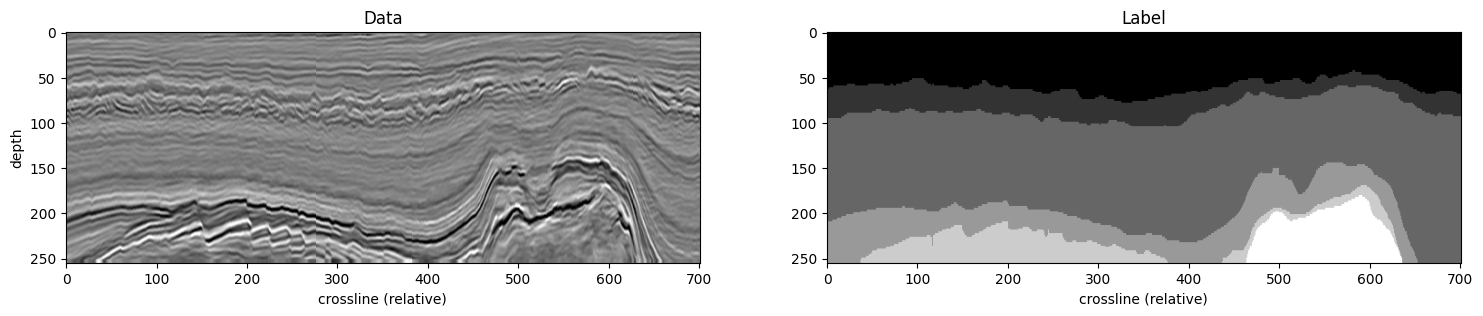

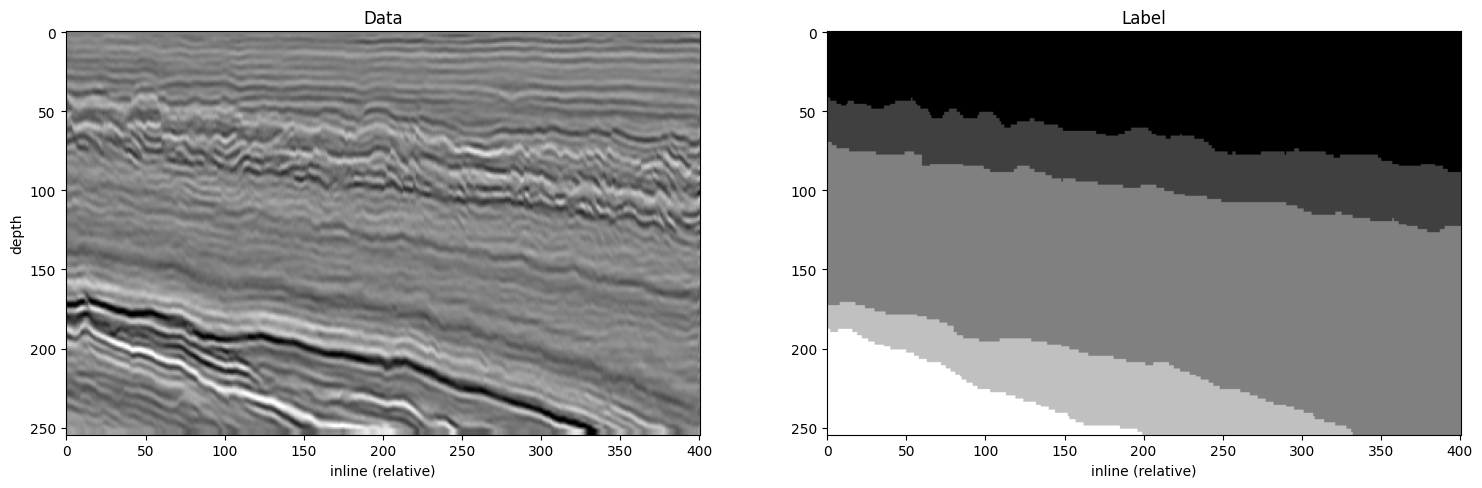

In [4]:
def plot_aline(aline, labels, xlabel, ylabel="depth"):
    """Plot a section of the data."""
    plt.figure(figsize=(18, 6))
    # data
    plt.subplot(1, 2, 1)
    plt.imshow(aline, cmap='gray') # seismic
    plt.title("Data")
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    # mask
    plt.subplot(1, 2, 2)
    plt.imshow(labels, cmap='gray') # seismic
    plt.xlabel(xlabel)
    plt.title("Label")

print("shape original: ", train_seismic.shape)
idx = 100
x_in = train_seismic[idx, :, :].swapaxes(0, 1)
x_inl = train_labels[idx, :, :].swapaxes(0, 1)

image_normalized = cv2.normalize(x_in, None, 0, 255, cv2.NORM_MINMAX)
image_normalized = np.uint8(image_normalized)
# # color_image = cv2.applyColorMap(image_normalized, cv2.COLORMAP_HSV)
# cv2.imwrite("inline.png", x_in)
# cv2.imwrite("img_test.png", image_normalized)
print("shape crossline: ", x_in.shape)
plot_aline(x_in, x_inl, xlabel="crossline (relative)")

x_cr = train_seismic[:, idx, :].swapaxes(0, 1)
x_crl = train_labels[:, idx, :].swapaxes(0, 1)

print("shape inline: ", x_cr.shape)
plot_aline(x_cr, x_crl, xlabel="inline (relative)")

## Preparando dataset para inserir no modelo SAM

In [5]:
def resize_image(image, target_shape):
  return cv2.resize(image, target_shape, interpolation=cv2.INTER_LINEAR)

def cria_patchs_sismicas_inline(images, patch_size=(256,256), step=256):
    all_img_patches = []
    for inline_idx in range(train_seismic.shape[1]): # iterando no inline
        large_image = train_seismic[:, inline_idx, :]
        target_shape = ((large_image.shape[1] // patch_size[1] + 1) * patch_size[1],
                        (large_image.shape[0] // patch_size[0] + 1) * patch_size[0])
        large_image_resized = resize_image(large_image, target_shape)
        patches_img = patchify(large_image_resized, patch_size=patch_size, step=step)  #Step=256 for 256 patches means no overlap

        for i in range(patches_img.shape[0]):
            for j in range(patches_img.shape[1]):

                single_patch_img = patches_img[i,j,:,:]
                all_img_patches.append(single_patch_img)
    return np.array(all_img_patches)

def cria_patchs_sismicas_crossline(images, patch_size=(256,256), step=256):
    all_img_patches = []
    for crossline_idx in range(train_seismic.shape[0]): # iterando no crossline
        large_image = train_seismic[crossline_idx, :, :]
        target_shape = ((large_image.shape[1] // patch_size[1] + 1) * patch_size[1],
                        (large_image.shape[0] // patch_size[0] + 1) * patch_size[0])
        large_image_resized = resize_image(large_image, target_shape)
        patches_img = patchify(large_image_resized, patch_size=patch_size, step=step)  #Step=256 for 256 patches means no overlap

        for i in range(patches_img.shape[0]):
            for j in range(patches_img.shape[1]):

                single_patch_img = patches_img[i,j,:,:]
                all_img_patches.append(single_patch_img)
    return np.array(all_img_patches)

def cria_patchs_labels_inline(images, patch_size=(256,256), step=256):
    all_mask_patches = []
    for inline_idx in range(train_labels.shape[1]): # iterando no inline
        large_mask = train_labels[:, inline_idx, :]
        target_shape = ((large_mask.shape[1] // patch_size[1] + 1) * patch_size[1],
                        (large_mask.shape[0] // patch_size[0] + 1) * patch_size[0])
        large_mask_resized = resize_image(large_mask, target_shape)
        patches_mask = patchify(large_mask_resized, patch_size=patch_size, step=step)  #Step=256 for 256 patches means no overlap

        for i in range(patches_mask.shape[0]):
            for j in range(patches_mask.shape[1]):

                single_patch_mask = patches_mask[i,j,:,:]
                # single_patch_mask = (single_patch_mask / 255.).astype(np.uint8)
                all_mask_patches.append(single_patch_mask)
    return np.array(all_mask_patches)

def cria_patchs_labels_crossline(images, patch_size=(256,256), step=256):
    all_mask_patches = []
    for crossline_idx in range(train_labels.shape[0]): # iterando no crossline
        large_mask = train_labels[crossline_idx, :, :]
        target_shape = ((large_mask.shape[1] // patch_size[1] + 1) * patch_size[1],
                        (large_mask.shape[0] // patch_size[0] + 1) * patch_size[0])
        large_mask_resized = resize_image(large_mask, target_shape)
        patches_mask = patchify(large_mask_resized, patch_size=patch_size, step=step)  #Step=256 for 256 patches means no overlap

        for i in range(patches_mask.shape[0]):
            for j in range(patches_mask.shape[1]):

                single_patch_mask = patches_mask[i,j,:,:]
                # single_patch_mask = (single_patch_mask / 255.).astype(np.uint8)
                all_mask_patches.append(single_patch_mask)
    return np.array(all_mask_patches)

images = np.concatenate((cria_patchs_sismicas_inline(train_seismic), cria_patchs_sismicas_crossline(train_seismic)), axis=0)
masks = np.concatenate((cria_patchs_labels_inline(train_labels), cria_patchs_labels_crossline(train_labels)), axis=0)

# Verificando a forma dos patches
print(f"Shape of all patches images: {images.shape}")
print(f"Shape of all patches masks: {masks.shape}")

Shape of all patches images: (2605, 256, 256)
Shape of all patches masks: (2605, 256, 256)


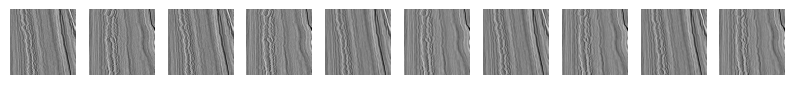

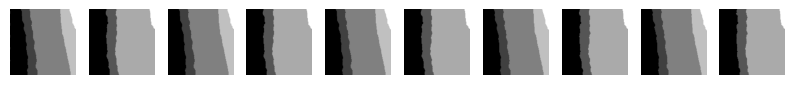

In [6]:
# Função para plotar alguns patches
def plot_patches(patches, num_patches=10):
    plt.figure(figsize=(10, 10))
    for i in range(num_patches):
        ax = plt.subplot(1, num_patches, i + 1)
        plt.imshow(patches[i], cmap='gray')
        plt.axis("off")
    plt.show()

# Plotando os primeiros 10 patches
plot_patches(images, num_patches=10)
plot_patches(masks, num_patches=10)

Image shape: (2605, 256, 256)
Mask shape: (2605, 256, 256)


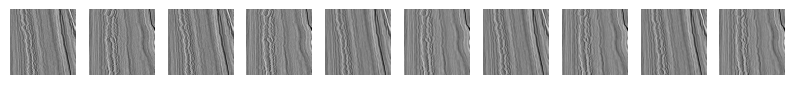

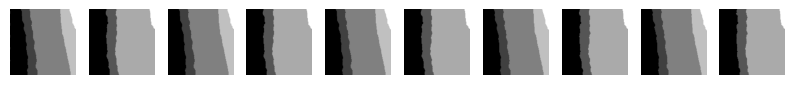

In [7]:
# Create a list to store the indices of non-empty masks
valid_indices = [i for i, mask in enumerate(masks) if mask.max() != 0]

# criar lista com imagens que tem 5 mascaras exatas
# def limite_retangulos_envolventes(image, limit=5):
#   unique_values = np.unique(image)
#   if len(unique_values) == limit:
#     return True
#   return False
# valid_indices = [i for i, mask in enumerate(masks) if limite_retangulos_envolventes(mask, 5)]

# Filter the image and mask arrays to keep only the non-empty pairs
filtered_images = images[valid_indices]
filtered_masks = masks[valid_indices]

print("Image shape:", filtered_images.shape)  # e.g., (num_frames, height, width, num_channels)
print("Mask shape:", filtered_masks.shape)
plot_patches(filtered_images, num_patches=10)
plot_patches(filtered_masks, num_patches=10)

In [8]:
# Convert the NumPy arrays to Pillow images and store them in a dictionary
dataset_dict = {
    "image": [Image.fromarray(img) for img in filtered_images],
    "label": [Image.fromarray(mask) for mask in filtered_masks],
}

# Create the dataset using the datasets.Dataset class
dataset = Dataset.from_dict(dataset_dict)

In [9]:
dataset

Dataset({
    features: ['image', 'label'],
    num_rows: 2605
})

In [16]:
# criando detector de retangulo envolvente na imagem das mascaras
def detecta_retangulo_envolvente(image):
    unique_values = np.unique(image)
    image_with_boxes = cv2.cvtColor(image, cv2.COLOR_GRAY2BGR)
    colors = [
        (0, 0, 255),
        (0, 255, 0),
        (255, 0, 0),
        (255, 0, 255),
        (0, 255, 255),
        (255, 255, 0),
        ]
    random.shuffle(colors)

    bboxes = []
    for i, value in enumerate(unique_values):
        mask = np.uint8(image == value) * 255

        contours, _ = cv2.findContours(mask, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
        for contour in contours:
            x, y, w, h = cv2.boundingRect(contour)
            x_max = x + w
            y_max = y + h
            bbox = [x, y, x+w, y+h]
            bboxes.append(bbox)
            # cv2.rectangle(image_with_boxes, (bbox[0], bbox[1]), (bbox[2], bbox[3]), colors[i], 2)
            # if len(contours) > 1: # quebra loop pra evitar bug de shape quebrado
            #   break

    # cv2.rectangle(image_with_boxes, (bboxes[-1][0], bboxes[-1][1]), (bboxes[-1][2], bboxes[-1][3]), (0, 0, 255), 2)
    # plt.imshow(cv2.cvtColor(image_with_boxes, cv2.COLOR_BGR2RGB))
    # plt.title('Retângulos Envolventes')
    # plt.axis('off')
    # plt.show()

    return bboxes[-1]

4 [208, 36, 256, 256]


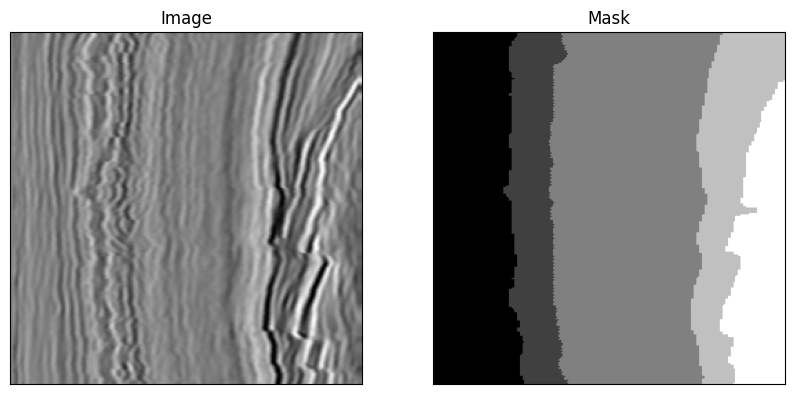

In [17]:
img_num = random.randint(0, filtered_images.shape[0]-1)
example_image = dataset[img_num]["image"]
example_mask = dataset[img_num]["label"]

bbox = detecta_retangulo_envolvente(np.array(example_mask))
print(len(bbox), bbox)

fig, axes = plt.subplots(1, 2, figsize=(10, 5))

# Plot the first image on the left
axes[0].imshow(np.array(example_image), cmap='gray')  # Assuming the first image is grayscale
axes[0].set_title("Image")

# Plot the second image on the right
axes[1].imshow(example_mask, cmap='gray')  # Assuming the second image is grayscale
axes[1].set_title("Mask")

# Hide axis ticks and labels
for ax in axes:
    ax.set_xticks([])
    ax.set_yticks([])
    ax.set_xticklabels([])
    ax.set_yticklabels([])

# Display the images side by side
plt.show()

In [18]:
from torch.utils.data import Dataset

class SAMDataset(Dataset):
  """
  This class is used to create a dataset that serves input images and masks.
  It takes a dataset and a processor as input and overrides the __len__ and __getitem__ methods of the Dataset class.
  """
  def __init__(self, dataset, processor):
    self.dataset = dataset
    self.processor = processor

  def __len__(self):
    return len(self.dataset)

  def __getitem__(self, idx):
    item = self.dataset[idx]
    image = item["image"]
    ground_truth_mask = np.array(item["label"])

    image = np.array(image)
    image = np.expand_dims(image, axis=-1)
    image = np.repeat(image, 3, axis=-1)
    image = cv2.normalize(image, None, 0, 255, cv2.NORM_MINMAX)
    image = np.uint8(image)

    # get bounding box prompt
    prompt = detecta_retangulo_envolvente(ground_truth_mask)
    # print(len(prompt))

    # prepare image and prompt for the model
    inputs = self.processor(image, input_boxes=[[prompt]], return_tensors="pt")

    # remove batch dimension which the processor adds by default
    inputs = {k:v.squeeze(0) for k,v in inputs.items()}

    # add ground truth segmentation
    inputs["ground_truth_mask"] = ground_truth_mask

    return inputs

In [19]:
# Initialize the processor
from transformers import SamProcessor
processor = SamProcessor.from_pretrained("facebook/sam-vit-base")

In [20]:
# Create an instance of the SAMDataset
train_dataset = SAMDataset(dataset=dataset, processor=processor)

In [21]:
example = train_dataset[0]
for k,v in example.items():
  print(k,v.shape)

pixel_values torch.Size([3, 1024, 1024])
original_sizes torch.Size([2])
reshaped_input_sizes torch.Size([2])
input_boxes torch.Size([1, 4])
ground_truth_mask (256, 256)


In [22]:
from torch.utils.data import DataLoader
train_dataloader = DataLoader(train_dataset, batch_size=2, shuffle=True, drop_last=False)

In [23]:
batch = next(iter(train_dataloader))
for k,v in batch.items():
  print(k,v.shape)

pixel_values torch.Size([2, 3, 1024, 1024])
original_sizes torch.Size([2, 2])
reshaped_input_sizes torch.Size([2, 2])
input_boxes torch.Size([2, 1, 4])
ground_truth_mask torch.Size([2, 256, 256])


In [24]:
batch["ground_truth_mask"].shape

torch.Size([2, 256, 256])

## Preparando modelo

In [25]:
from transformers import SamModel
model = SamModel.from_pretrained("facebook/sam-vit-base")

# make sure we only compute gradients for mask decoder
for name, param in model.named_parameters():
  if name.startswith("vision_encoder") or name.startswith("prompt_encoder"):
    param.requires_grad_(False)

In [26]:
from torch.optim import Adam
import monai
# Initialize the optimizer and the loss function
optimizer = Adam(model.mask_decoder.parameters(), lr=1e-5, weight_decay=0)
#Try DiceFocalLoss, FocalLoss, DiceCELoss
seg_loss = monai.losses.DiceFocalLoss(sigmoid=True, squared_pred=True, reduction='mean')

In [27]:
from tqdm import tqdm
from statistics import mean
import torch
from torch.nn.functional import threshold, normalize

device = "cuda" if torch.cuda.is_available() else "cpu"
model.to(device)

print(device)

cuda


In [26]:
#Training loop
num_epochs = 10

model.train()
for epoch in range(num_epochs):
    epoch_losses = []
    for batch in tqdm(train_dataloader):
      # print(batch["ground_truth_mask"].shape)
      # forward pass
      outputs = model(pixel_values=batch["pixel_values"].to(device),
                      input_boxes=batch["input_boxes"].to(device),
                      multimask_output=False)

      # compute loss
      predicted_masks = outputs.pred_masks.squeeze(1)
      ground_truth_masks = batch["ground_truth_mask"].float().to(device)
      loss = seg_loss(predicted_masks, ground_truth_masks.unsqueeze(1))

      # backward pass (compute gradients of parameters w.r.t. loss)
      optimizer.zero_grad()
      loss.backward()

      # optimize
      optimizer.step()
      epoch_losses.append(loss.item())

    print(f'EPOCH: {epoch}')
    print(f'Mean loss: {mean(epoch_losses)}')
    # torch.save(model.state_dict(), "/content/drive/MyDrive/UNICAMP/master tesis/sam/model/sam_seismic_checkpoint.pth")
    torch.save(model.state_dict(), "model/sam_seismic_checkpoint.pth")

100%|██████████| 1303/1303 [04:45<00:00,  4.56it/s]


EPOCH: 0
Mean loss: 46.84560863059571


100%|██████████| 1303/1303 [04:52<00:00,  4.45it/s]


EPOCH: 1
Mean loss: 0.29416216198563666


100%|██████████| 1303/1303 [04:57<00:00,  4.38it/s]


EPOCH: 2
Mean loss: 0.28403999459167123


100%|██████████| 1303/1303 [04:49<00:00,  4.50it/s]


EPOCH: 3
Mean loss: 0.2838400269666271


100%|██████████| 1303/1303 [04:56<00:00,  4.40it/s]


EPOCH: 4
Mean loss: 0.283586926661083


100%|██████████| 1303/1303 [04:51<00:00,  4.46it/s]


EPOCH: 5
Mean loss: 0.2834110091442524


100%|██████████| 1303/1303 [04:50<00:00,  4.49it/s]


EPOCH: 6
Mean loss: 0.2832963024298228


100%|██████████| 1303/1303 [04:56<00:00,  4.39it/s]


EPOCH: 7
Mean loss: 0.28307337607224903


100%|██████████| 1303/1303 [04:47<00:00,  4.53it/s]


EPOCH: 8
Mean loss: 0.2829532796547034


100%|██████████| 1303/1303 [04:54<00:00,  4.42it/s]


EPOCH: 9
Mean loss: 0.2826872847899966


## inferencia

In [28]:
from transformers import SamModel, SamConfig, SamProcessor
import torch

In [29]:
# Load the model configuration
model_config = SamConfig.from_pretrained("facebook/sam-vit-base")
processor = SamProcessor.from_pretrained("facebook/sam-vit-base")

# Create an instance of the model architecture with the loaded configuration
my_mito_model = SamModel(config=model_config)
#Update the model by loading the weights from saved file.
# my_mito_model.load_state_dict(torch.load("/content/drive/MyDrive/UNICAMP/master tesis/sam/model/sam_seismic_checkpoint.pth"))
my_mito_model.load_state_dict(torch.load("model/sam_seismic_checkpoint.pth"))

<All keys matched successfully>

In [30]:
device = "cuda" if torch.cuda.is_available() else "cpu"
my_mito_model.to(device)

SamModel(
  (shared_image_embedding): SamPositionalEmbedding()
  (vision_encoder): SamVisionEncoder(
    (patch_embed): SamPatchEmbeddings(
      (projection): Conv2d(3, 768, kernel_size=(16, 16), stride=(16, 16))
    )
    (layers): ModuleList(
      (0-11): 12 x SamVisionLayer(
        (layer_norm1): LayerNorm((768,), eps=1e-06, elementwise_affine=True)
        (attn): SamVisionAttention(
          (qkv): Linear(in_features=768, out_features=2304, bias=True)
          (proj): Linear(in_features=768, out_features=768, bias=True)
        )
        (layer_norm2): LayerNorm((768,), eps=1e-06, elementwise_affine=True)
        (mlp): SamMLPBlock(
          (lin1): Linear(in_features=768, out_features=3072, bias=True)
          (lin2): Linear(in_features=3072, out_features=768, bias=True)
          (act): GELUActivation()
        )
      )
    )
    (neck): SamVisionNeck(
      (conv1): Conv2d(768, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (layer_norm1): SamLayerNorm()
     

(256, 256, 3)


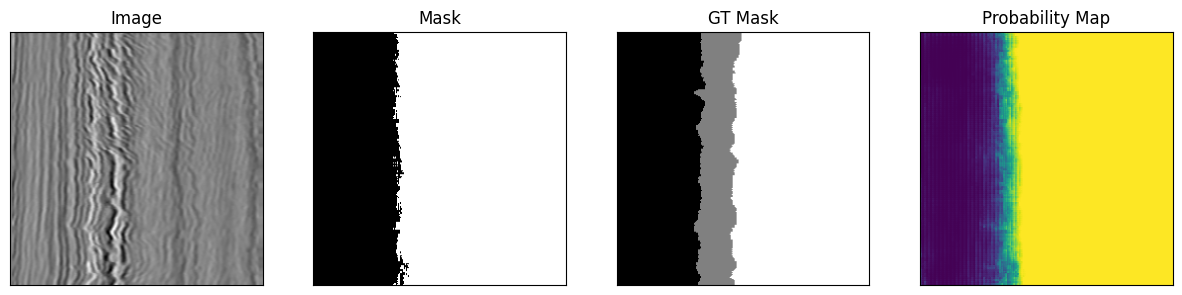

In [35]:
import numpy as np
import random
import torch
import matplotlib.pyplot as plt

# let's take a random training example
idx = random.randint(0, filtered_images.shape[0]-1)

# load image
test_image = dataset[idx]["image"]

# get box prompt based on ground truth segmentation map
ground_truth_mask = np.array(dataset[idx]["label"])
prompt = detecta_retangulo_envolvente(ground_truth_mask)

test_image = np.array(test_image)
test_image = np.expand_dims(test_image, axis=-1)
test_image = np.repeat(test_image, 3, axis=-1)
test_image = cv2.normalize(test_image, None, 0, 255, cv2.NORM_MINMAX)
test_image = np.uint8(test_image)

print(test_image.shape)

# prepare image + box prompt for the model
inputs = processor(test_image, input_boxes=[[prompt]], return_tensors="pt")

# Move the input tensor to the GPU if it's not already there
inputs = {k: v.to(device) for k, v in inputs.items()}

my_mito_model.eval()

# forward pass
with torch.no_grad():
    outputs = my_mito_model(**inputs, multimask_output=False)

# apply sigmoid
medsam_seg_prob = torch.sigmoid(outputs.pred_masks.squeeze(1))
# convert soft mask to hard mask
medsam_seg_prob = medsam_seg_prob.cpu().numpy().squeeze()
medsam_seg = (medsam_seg_prob > 0.5).astype(np.uint8)


fig, axes = plt.subplots(1, 4, figsize=(15, 5))

# Plot the first image on the left
axes[0].imshow(np.array(test_image), cmap='gray')  # Assuming the first image is grayscale
axes[0].set_title("Image")

# Plot the second image on the right
axes[1].imshow(medsam_seg, cmap='gray')  # Assuming the second image is grayscale
axes[1].set_title("Mask")

axes[2].imshow(ground_truth_mask, cmap='gray')  # Assuming the second image is grayscale
axes[2].set_title("GT Mask")

# Plot the second image on the right
axes[3].imshow(medsam_seg_prob)  # Assuming the second image is grayscale
axes[3].set_title("Probability Map")

# Hide axis ticks and labels
for ax in axes:
    ax.set_xticks([])
    ax.set_yticks([])
    ax.set_xticklabels([])
    ax.set_yticklabels([])

# Display the images side by side
plt.show()

In [41]:
images[0]

(2605, 256, 256)

In [37]:
# teste

(255, 701)